<a href="https://colab.research.google.com/github/sk23aca/Barclays-Stock-Price-Prediction-Using-Advanced-ML/blob/main/Barclays_stock_Pred_(BARC_L)_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Necessary Libraries:**

Ensure you have the required libraries installed:

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, timedelta
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric




#**Fetching Barclays Stock Data:**
 New section
 The ticker symbol for Barclays on the London Stock Exchange is BARC.L.

In [ ]:
from datetime import date
import yfinance as yf

# Define the corrected ticker symbol
ticker_symbol = 'BARC.L'  # Adjusted for yfinance compatibility

# Define the date range
start_date = '2014-01-01'
end_date = date.today().strftime('%Y-%m-%d')

# Download historical data
barclays_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')

# Sort data by date
barclays_data.sort_index(inplace=True)

# Display the data
print(barclays_data.tail())


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker          BARC.L      BARC.L      BARC.L      BARC.L    BARC.L
Date                                                                
2025-04-11  257.950012  264.299988  251.050003  262.649994  74749197
2025-04-14  270.399994  272.850006  262.049988  263.549988  30875395
2025-04-15  279.200012  279.600006  269.100006  270.049988  42882246
2025-04-16  278.000000  278.770996  273.500000  275.000000  82382137
2025-04-17  277.299988  279.700012  274.149994  278.000000  27299550


#**Calculating Technical Indicators:**

We'll compute the following features using past data (shifted by one day to prevent data leakage):

Moving Averages: 5-day, 10-day, and 50-day moving averages of the closing price.


Daily Returns: Percentage change in the closing price from the previous day.


Volatility: Rolling standard deviation of daily returns over a 10-day window.

In [ ]:
# Calculate moving averages (shifted by 1 day)
barclays_data['MA_5'] = barclays_data['Close'].rolling(window=5).mean().shift(1)
barclays_data['MA_10'] = barclays_data['Close'].rolling(window=10).mean().shift(1)
barclays_data['MA_50'] = barclays_data['Close'].rolling(window=50).mean().shift(1)

# Calculate daily returns (shifted by 1 day)
barclays_data['Daily_Returns'] = barclays_data['Close'].pct_change().shift(1) * 100

# Calculate volatility (rolling standard deviation of returns, shifted by 1 day)
barclays_data['Volatility'] = barclays_data['Daily_Returns'].rolling(window=10).std().shift(1)

# Drop rows with NaN values resulting from rolling calculations
barclays_data.dropna(inplace=True)



**Defining Features and Target Variable:**
We'll define our feature set (X) and target variable (y):

In [ ]:
# Define features (X) and target variable (y)
X = barclays_data[['MA_5', 'MA_10', 'MA_50', 'Daily_Returns', 'Volatility']]
y = barclays_data['Close']


#**Splitting the Data into Training and Testing Sets:**

We'll split the data based on time to create training and testing datasets:

In [ ]:
# Split data into training and testing sets
train_data = barclays_data[barclays_data.index < '2023-01-01']
test_data = barclays_data[barclays_data.index >= '2023-01-01']

X_train = train_data[['MA_5', 'MA_10', 'MA_50', 'Daily_Returns', 'Volatility']]
y_train = train_data['Close']
X_test = test_data[['MA_5', 'MA_10', 'MA_50', 'Daily_Returns', 'Volatility']]
y_test = test_data['Close']

Saving the Datasets to CSV Files:

Finally, we'll save the datasets to CSV files for future use:

In [ ]:
# Save datasets to CSV files
train_data.to_csv("barclays_train_data.csv")
test_data.to_csv("barclays_test_data.csv")
X_train.to_csv("barclays_train_features.csv")
y_train.to_csv("barclays_train_target.csv")
X_test.to_csv("barclays_test_features.csv")
y_test.to_csv("barclays_test_target.csv")

Reading CSV Files

In [ ]:
# train_data = pd.read_csv("barclays_train_data.csv")
# test_data = pd.read_csv("barclays_test_data.csv")
# X_train = pd.read_csv("barclays_train_features.csv")
# y_train = pd.read_csv("barclays_train_target.csv")
# X_test = pd.read_csv("barclays_test_features.csv")
# y_test = pd.read_csv("barclays_test_target.csv")


In [ ]:
# Printing the total number of days and features in the dataset
print('Total number of days present in the dataset:', barclays_data.shape[0])
print('Total number of fields present in the dataset:', barclays_data.shape[1])

Total number of days present in the dataset: 2805
Total number of fields present in the dataset: 10


In [ ]:
# Checking the null values
print('Null Values:',barclays_data.isnull().values.sum())
print('NA values:',barclays_data.isnull().values.any())

Null Values: 0
NA values: False


In [ ]:
barclays_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2805 entries, 2014-03-13 to 2025-04-17
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BARC.L)    2805 non-null   float64
 1   (High, BARC.L)     2805 non-null   float64
 2   (Low, BARC.L)      2805 non-null   float64
 3   (Open, BARC.L)     2805 non-null   float64
 4   (Volume, BARC.L)   2805 non-null   int64  
 5   (MA_5, )           2805 non-null   float64
 6   (MA_10, )          2805 non-null   float64
 7   (MA_50, )          2805 non-null   float64
 8   (Daily_Returns, )  2805 non-null   float64
 9   (Volatility, )     2805 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 241.1 KB


In [ ]:
barclays_data.head()

Price,Close,High,Low,Open,Volume,MA_5,MA_10,MA_50,Daily_Returns,Volatility
Ticker,BARC.L,BARC.L,BARC.L,BARC.L,BARC.L,,,,,
Date,,,,,,,,,,
2014-03-13,234.928268,239.613886,234.230415,234.778734,64888340,241.966656,246.502716,266.085545,-1.016286,1.490315
2014-03-14,230.442001,237.919029,227.589772,234.878384,73837468,238.447461,244.683305,265.380438,0.812821,1.452718
2014-03-17,230.342377,232.951366,229.245740,231.389164,46130614,235.017981,242.594717,264.549720,-1.909633,1.503711
2014-03-18,235.327087,237.271112,229.494997,231.090103,57727630,232.834698,240.919867,263.624306,-0.043232,1.548841
2014-03-19,240.760345,242.554836,231.454934,237.769534,64501431,232.814771,239.235046,262.729807,2.164044,1.537765


**Flatten the MultiIndex Columns:**

First, we'll flatten the MultiIndex columns to simplify the DataFrame structure.

In [ ]:
# Flatten MultiIndex columns
barclays_data.columns = ['_'.join(filter(None, col)).strip() for col in barclays_data.columns.values]

# Display the updated columns
print(barclays_data.columns)

Index(['Close_BARC.L', 'High_BARC.L', 'Low_BARC.L', 'Open_BARC.L',
       'Volume_BARC.L', 'MA_5', 'MA_10', 'MA_50', 'Daily_Returns',
       'Volatility'],
      dtype='object')


Resample the Data:

Next, we'll resample the data to weekly, monthly, and yearly frequencies. For each period, we'll compute the opening price (first value), closing price (last value), highest price, lowest price, and total volume.

In [ ]:
# Resample to weekly frequency
barclays_weekly = barclays_data.resample('W').agg({
    'Open_BARC.L': 'first',
    'High_BARC.L': 'max',
    'Low_BARC.L': 'min',
    'Close_BARC.L': 'last',
    'Volume_BARC.L': 'sum'
})

# Resample to monthly frequency
barclays_monthly = barclays_data.resample('M').agg({
    'Open_BARC.L': 'first',
    'High_BARC.L': 'max',
    'Low_BARC.L': 'min',
    'Close_BARC.L': 'last',
    'Volume_BARC.L': 'sum'
})

# Resample to yearly frequency
barclays_yearly = barclays_data.resample('A').agg({
    'Open_BARC.L': 'first',
    'High_BARC.L': 'max',
    'Low_BARC.L': 'min',
    'Close_BARC.L': 'last',
    'Volume_BARC.L': 'sum'
})


# **Plot the Data:**

We'll create subplots to visualize the open and closing prices for daily, weekly, monthly, and yearly data.

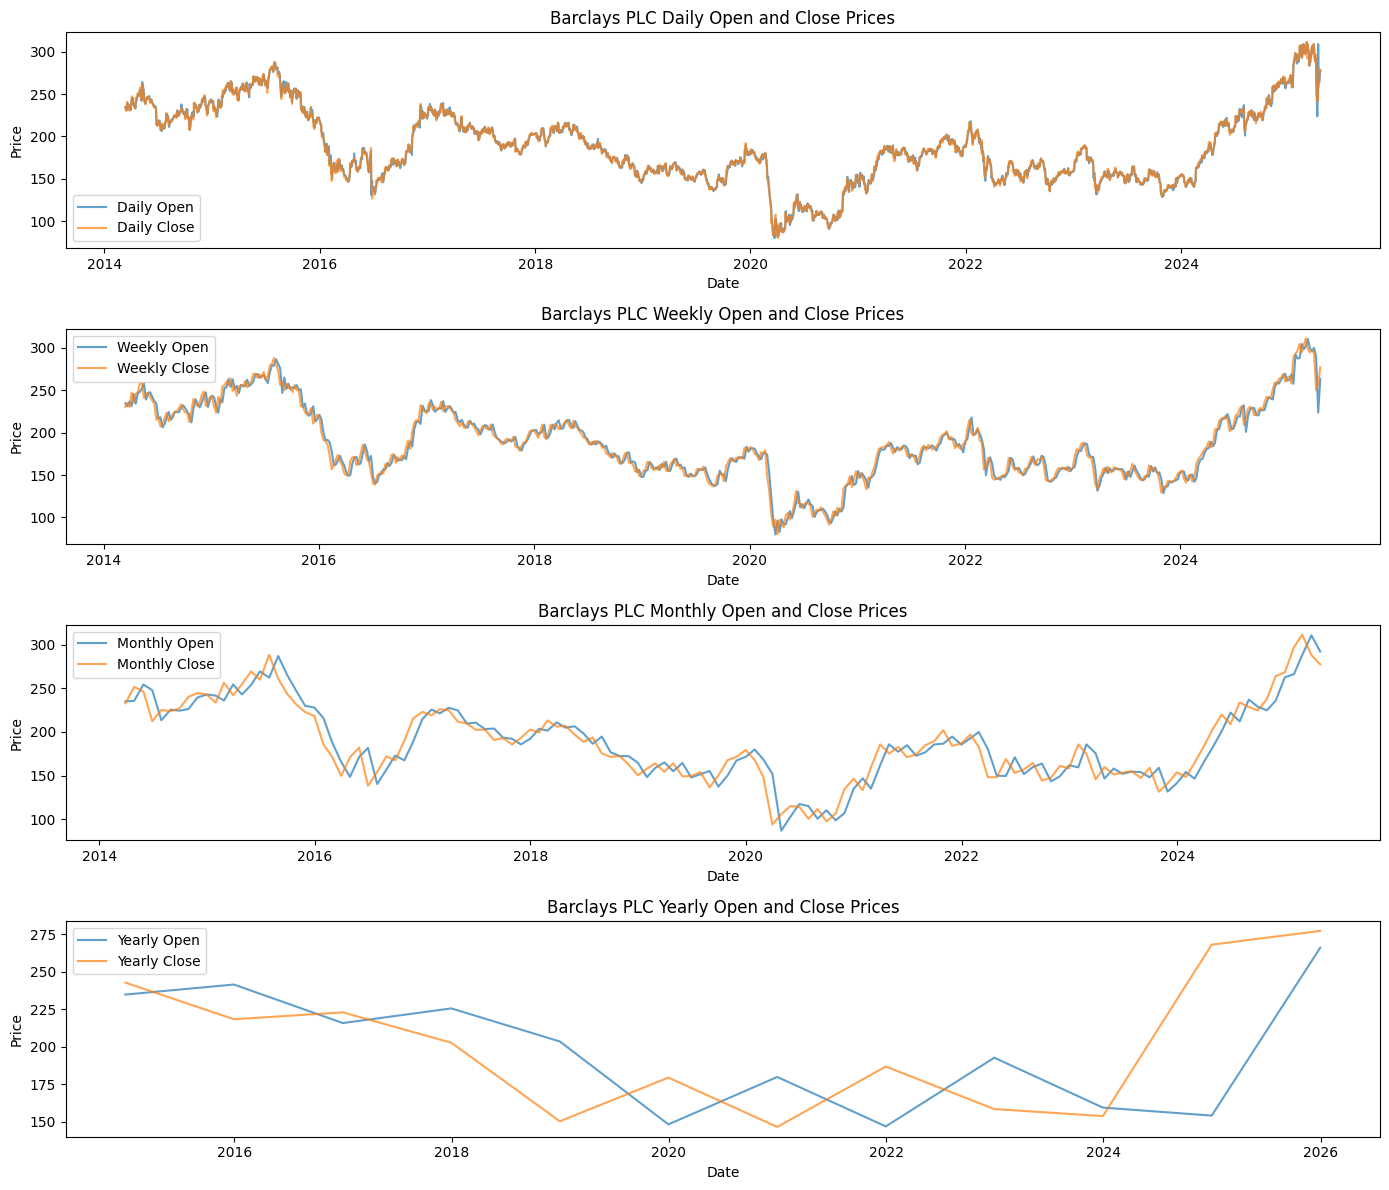

In [ ]:

plt.figure(figsize=(14, 12))

# Daily Open and Close Prices
plt.subplot(4, 1, 1)
plt.plot(barclays_data.index, barclays_data['Open_BARC.L'], label='Daily Open', alpha=0.7)
plt.plot(barclays_data.index, barclays_data['Close_BARC.L'], label='Daily Close', alpha=0.7)
plt.title('Barclays PLC Daily Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Weekly Open and Close Prices
plt.subplot(4, 1, 2)
plt.plot(barclays_weekly.index, barclays_weekly['Open_BARC.L'], label='Weekly Open', alpha=0.7)
plt.plot(barclays_weekly.index, barclays_weekly['Close_BARC.L'], label='Weekly Close', alpha=0.7)
plt.title('Barclays PLC Weekly Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Monthly Open and Close Prices
plt.subplot(4, 1, 3)
plt.plot(barclays_monthly.index, barclays_monthly['Open_BARC.L'], label='Monthly Open', alpha=0.7)
plt.plot(barclays_monthly.index, barclays_monthly['Close_BARC.L'], label='Monthly Close', alpha=0.7)
plt.title('Barclays PLC Monthly Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Yearly Open and Close Prices
plt.subplot(4, 1, 4)
plt.plot(barclays_yearly.index, barclays_yearly['Open_BARC.L'], label='Yearly Open', alpha=0.7)
plt.plot(barclays_yearly.index, barclays_yearly['Close_BARC.L'], label='Yearly Close', alpha=0.7)
plt.title('Barclays PLC Yearly Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


# **LSTM Model**

In [ ]:
# Utility function to create dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
future_steps = 30


In [ ]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


**Forecasting OPEN Price for LSTM Model**

In [ ]:
# Scaling the Open price
scaler_open = MinMaxScaler(feature_range=(0, 1))
scaled_open = scaler_open.fit_transform(barclays_data['Open_BARC.L'].values.reshape(-1, 1))

# Creating dataset for Open price
X_open, Y_open = create_dataset(scaled_open, time_step)
X_open = X_open.reshape(X_open.shape[0], X_open.shape[1], 1)

train_size_open = int(len(X_open) * 0.8)
X_train_open, X_test_open = X_open[:train_size_open], X_open[train_size_open:]
Y_train_open, Y_test_open = Y_open[:train_size_open], Y_open[train_size_open:]

# LSTM model
lstm_model_open = Sequential()
lstm_model_open.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model_open.add(LSTM(50, return_sequences=False))
lstm_model_open.add(Dense(25))
lstm_model_open.add(Dense(1))
lstm_model_open.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_open.fit(X_train_open, Y_train_open, batch_size=1, epochs=1)

# Forecasting future 30 days
last_window_open = scaled_open[-time_step:]
temp_input_open = list(last_window_open.flatten())
lst_output_open = []
for i in range(future_steps):
    x_input_open = np.array(temp_input_open[-time_step:]).reshape(1, time_step, 1)
    yhat_open = lstm_model_open.predict(x_input_open, verbose=0)
    lst_output_open.append(yhat_open[0][0])
    temp_input_open.append(yhat_open[0][0])
future_predictions_open = scaler_open.inverse_transform(np.array(lst_output_open).reshape(-1, 1))



2163/2163 ━━━━━━━━━━━━━━━━━━━━ 90s 41ms/step - loss: 0.0048


**Evaluate Test Performance and Plot Actual vs Predicted for Open Price for LSTM**

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Open Price Model Evaluation Metrics:
MSE: 54.5474
RMSE: 7.3856
MAE: 4.6518
MAPE:30.9783
R²: 0.9804


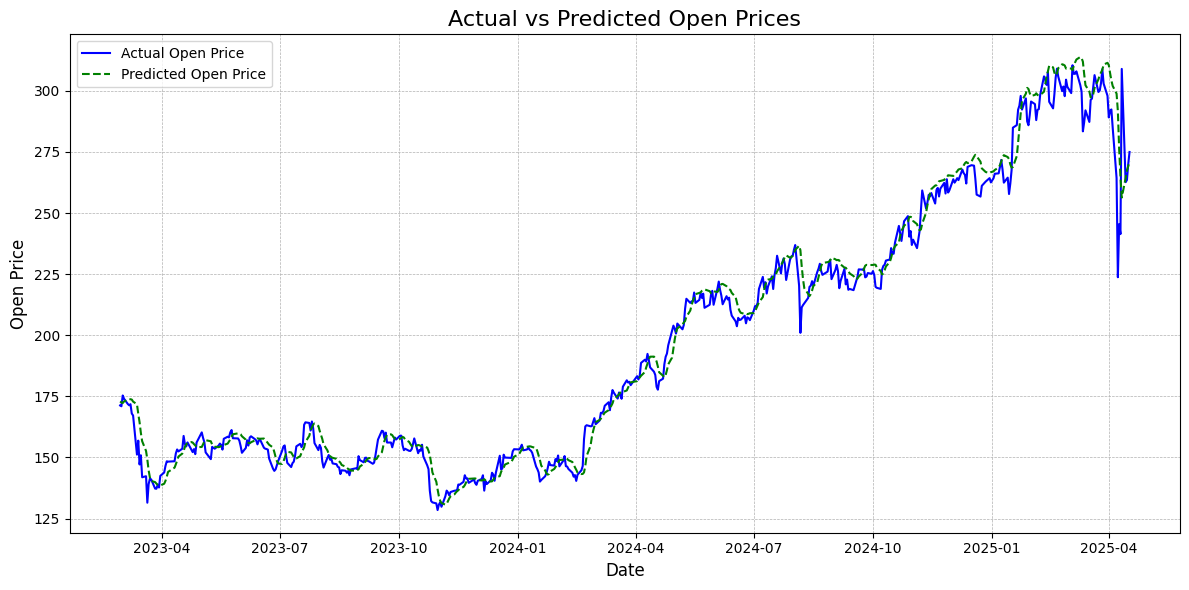

In [ ]:

Y_test_open_actual = scaler_open.inverse_transform(Y_test_open.reshape(-1, 1))
lstm_test_predictions_open = lstm_model_open.predict(X_test_open)
lstm_test_predictions_open = scaler_open.inverse_transform(lstm_test_predictions_open)

open_mse = mean_squared_error(Y_test_open_actual, lstm_test_predictions_open)
open_rmse = np.sqrt(open_mse)
open_mae = mean_absolute_error(Y_test_open_actual, lstm_test_predictions_open)
open_mape = calculate_mape(Y_test_open_actual, lstm_test_predictions_open.flatten())
open_r2 = r2_score(Y_test_open_actual, lstm_test_predictions_open)

print("\nOpen Price Model Evaluation Metrics:")
print(f"MSE: {open_mse:.4f}")
print(f"RMSE: {open_rmse:.4f}")
print(f"MAE: {open_mae:.4f}")
print(f"MAPE:{open_mape:.4f}")
print(f"R²: {open_r2:.4f}")

dates_test_open = barclays_data.index[train_size_open + time_step + 1:train_size_open + time_step + 1 + len(Y_test_open)]


plt.figure(figsize=(12,6))
plt.plot(dates_test_open, Y_test_open_actual, label='Actual Open Price', color='blue')
plt.plot(dates_test_open, lstm_test_predictions_open, label='Predicted Open Price', color='green', linestyle='--')
plt.title('Actual vs Predicted Open Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Open Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

**Forecasting CLOSE Price LSTM Model**

In [ ]:
scaler_close = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler_close.fit_transform(barclays_data['Close_BARC.L'].values.reshape(-1, 1))

X_close, Y_close = create_dataset(scaled_close, time_step)
X_close = X_close.reshape(X_close.shape[0], X_close.shape[1], 1)

train_size_close = int(len(X_close) * 0.8)
X_train_close, X_test_close = X_close[:train_size_close], X_close[train_size_close:]
Y_train_close, Y_test_close = Y_close[:train_size_close], Y_close[train_size_close:]

# LSTM model
lstm_model_close = Sequential()
lstm_model_close.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model_close.add(LSTM(50, return_sequences=False))
lstm_model_close.add(Dense(25))
lstm_model_close.add(Dense(1))
lstm_model_close.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_close.fit(X_train_close, Y_train_close, batch_size=1, epochs=1)

# Forecasting future 30 days
last_window_close = scaled_close[-time_step:]
temp_input_close = list(last_window_close.flatten())
lst_output_close = []
for i in range(future_steps):
    x_input_close = np.array(temp_input_close[-time_step:]).reshape(1, time_step, 1)
    yhat_close = lstm_model_close.predict(x_input_close, verbose=0)
    lst_output_close.append(yhat_close[0][0])
    temp_input_close.append(yhat_close[0][0])
future_predictions_close = scaler_close.inverse_transform(np.array(lst_output_close).reshape(-1, 1))



2163/2163 ━━━━━━━━━━━━━━━━━━━━ 94s 42ms/step - loss: 0.0085


**Evaluate Test Performance and Plot Actual vs Predicted for Close Price for LSTM**

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Close Price Model Evaluation Metrics:
MSE: 36.8698
RMSE: 6.0720
MAE: 4.3881
MAPE:30.4889
R²: 0.9868


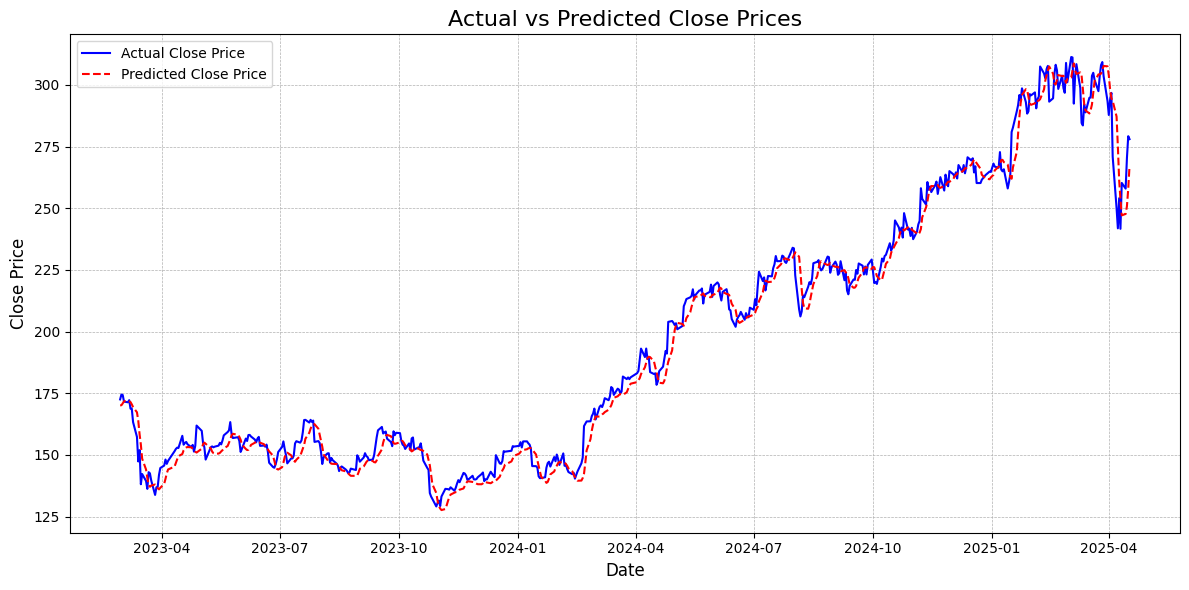

In [ ]:

Y_test_close_actual = scaler_close.inverse_transform(Y_test_close.reshape(-1, 1))
lstm_test_predictions_close = lstm_model_close.predict(X_test_close)
lstm_test_predictions_close = scaler_close.inverse_transform(lstm_test_predictions_close)

close_mse = mean_squared_error(Y_test_close_actual, lstm_test_predictions_close)
close_rmse = np.sqrt(close_mse)
close_mae = mean_absolute_error(Y_test_close_actual, lstm_test_predictions_close)
close_mape = calculate_mape(Y_test_close_actual, lstm_test_predictions_close.flatten())
close_r2 = r2_score(Y_test_close_actual, lstm_test_predictions_close)

print("\nClose Price Model Evaluation Metrics:")
print(f"MSE: {close_mse:.4f}")
print(f"RMSE: {close_rmse:.4f}")
print(f"MAE: {close_mae:.4f}")
print(f"MAPE:{close_mape:.4f}")
print(f"R²: {close_r2:.4f}")

# Geting the dates from the index of the original data corresponding to the test data
dates_test_close = barclays_data.index[train_size_close + time_step + 1:train_size_close + time_step + 1 + len(Y_test_close)]


plt.figure(figsize=(12,6))
plt.plot(dates_test_close, Y_test_close_actual, label='Actual Close Price', color='blue')
plt.plot(dates_test_close, lstm_test_predictions_close, label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Close Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

30 Days Plot Future Predictions for LSTM


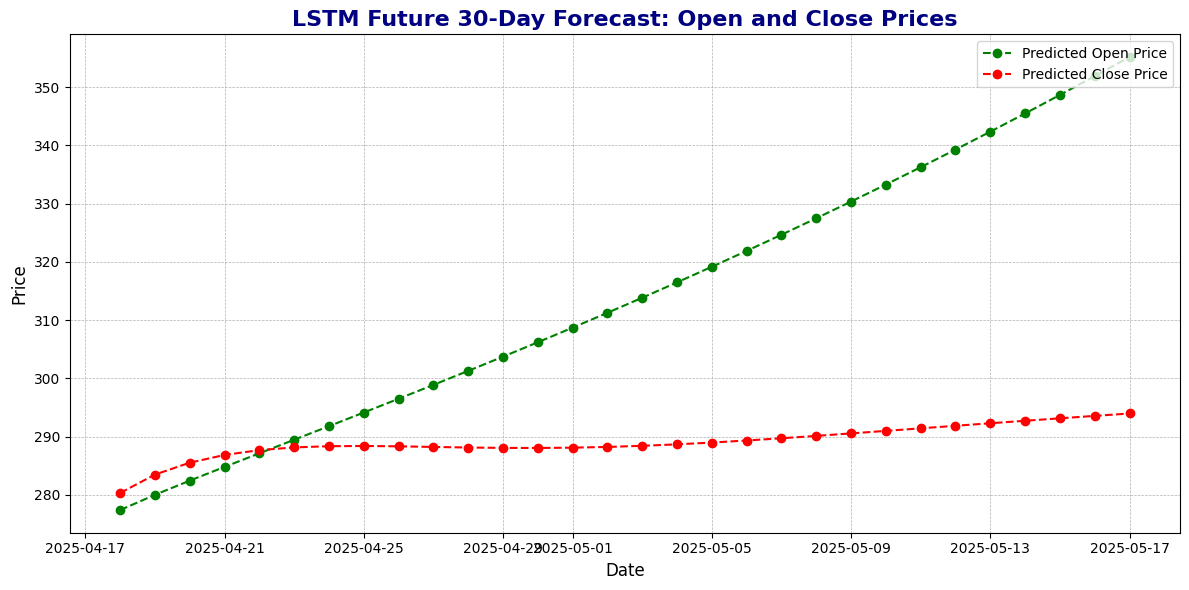

In [ ]:
# Checking if 'Date_' exists:
if 'Date_' in barclays_data.columns:
    last_date = pd.to_datetime(barclays_data['Date_'].iloc[-1])
else:
    last_date = barclays_data.index[-1]

future_dates = [last_date + pd.DateOffset(days=i+1) for i in range(future_steps)]

# Creating a DataFrame with predicted Open and Close prices
futureLSTM_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Open': future_predictions_open.flatten(),
    'Predicted Close': future_predictions_close.flatten()
})


plt.figure(figsize=(12,6))
plt.plot(futureLSTM_df['Date'], futureLSTM_df['Predicted Open'], label='Predicted Open Price', linestyle='--', marker='o', color='green')
plt.plot(futureLSTM_df['Date'], futureLSTM_df['Predicted Close'], label='Predicted Close Price', linestyle='--', marker='o', color='red')
plt.title('LSTM Future 30-Day Forecast: Open and Close Prices', fontsize=16, color='navy', weight='bold')
plt.xlabel('Date', fontsize=12, color='k')
plt.ylabel('Price', fontsize=12, color='k')
plt.legend(frameon=True, loc='upper right', fontsize=10)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:

print("Future 30-day Predictions (Open & Close):")
print(futureLSTM_df)

Future 30-day Predictions (Open & Close):
         Date  Predicted Open  Predicted Close
0  2025-04-18      277.385498       280.320435
1  2025-04-19      280.001587       283.475403
2  2025-04-20      282.435699       285.520569
3  2025-04-21      284.796875       286.849030
4  2025-04-22      287.130890       287.676483
5  2025-04-23      289.458649       288.142639
6  2025-04-24      291.790894       288.352325
7  2025-04-25      294.134796       288.391205
8  2025-04-26      296.495728       288.330261
9  2025-04-27      298.878448       288.227112
10 2025-04-28      301.287292       288.126190
11 2025-04-29      303.726257       288.059387
12 2025-04-30      306.198730       288.047516
13 2025-05-01      308.708008       288.101959
14 2025-05-02      311.256744       288.226288
15 2025-05-03      313.847321       288.418518
16 2025-05-04      316.481750       288.672577
17 2025-05-05      319.161713       288.979919
18 2025-05-06      321.888580       289.330811
19 2025-05-07     

# **Prophat Model**

In [ ]:
import pandas as pd
from prophet import Prophet

print("Columns available in test_data:", test_data.columns)

# Flatten MultiIndex columns
test_data.columns = ['_'.join(filter(None, col)).strip() for col in test_data.columns.values]

close_col = 'Close_BARC.L'
open_col = 'Open_BARC.L'

if close_col not in test_data.columns:
    raise KeyError(f"Column {close_col} not found in test_data. Available columns: {test_data.columns}")
if open_col not in test_data.columns:
    raise KeyError(f"Column {open_col} not found in test_data. Available columns: {test_data.columns}")

# Prepareing data for Prophet for close price
close_data = barclays_data[['Close_BARC.L']].reset_index()
close_data.rename(columns={'Date': 'ds', 'Close_BARC.L': 'y'}, inplace=True)

# Preparing data for Prophet for open price
open_data = barclays_data[['Open_BARC.L']].reset_index()
open_data.rename(columns={'Date': 'ds', 'Open_BARC.L': 'y'}, inplace=True)



Columns available in test_data: MultiIndex([(        'Close', 'BARC.L'),
            (         'High', 'BARC.L'),
            (          'Low', 'BARC.L'),
            (         'Open', 'BARC.L'),
            (       'Volume', 'BARC.L'),
            (         'MA_5',       ''),
            (        'MA_10',       ''),
            (        'MA_50',       ''),
            ('Daily_Returns',       ''),
            (   'Volatility',       '')],
           names=['Price', 'Ticker'])


In [ ]:
# Initializing and fiting the Prophet model for Close price
close_model = Prophet(daily_seasonality=True)
close_model.fit(close_data)

# Creating a DataFrame
close_future = close_model.make_future_dataframe(periods=0)
close_forecast = close_model.predict(close_future)


prophet_model = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

prophet_model.fit(open_data)

# Forecasting
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)


13:20:23 - cmdstanpy - INFO - Chain [1] start processing
13:20:26 - cmdstanpy - INFO - Chain [1] done processing
13:20:28 - cmdstanpy - INFO - Chain [1] start processing
13:20:31 - cmdstanpy - INFO - Chain [1] done processing



Open Price Model Evaluation Metrics:
MSE: 218.9536
RMSE: 14.7971
MAE: 10.4480
MAPE:6.1844
R²: 0.8853


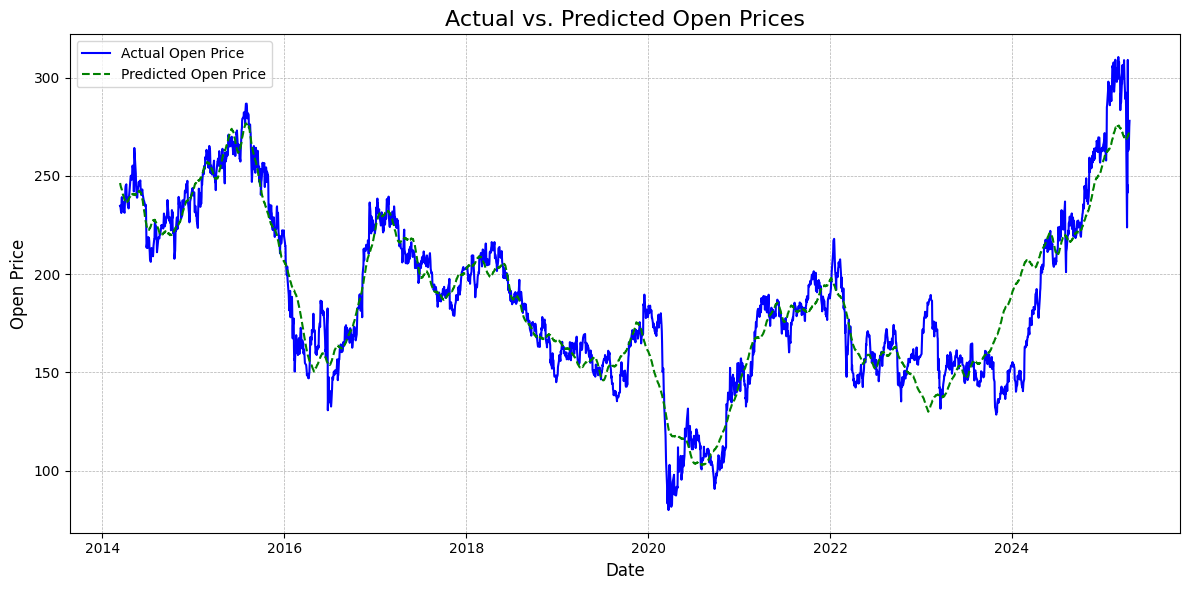

In [ ]:
open_merged = pd.merge(open_data, forecast[['ds', 'yhat']], on='ds')

# Calculating metrics for Open price
open_mse = mean_squared_error(open_merged['y'], open_merged['yhat'])
open_rmse = np.sqrt(open_mse)
open_mae = mean_absolute_error(open_merged['y'], open_merged['yhat'])
open_mape = calculate_mape(open_merged['y'], open_merged['yhat'])
open_r2 = r2_score(open_merged['y'], open_merged['yhat'])

print("\nOpen Price Model Evaluation Metrics:")
print(f"MSE: {open_mse:.4f}")
print(f"RMSE: {open_rmse:.4f}")
print(f"MAE: {open_mae:.4f}")
print(f"MAPE:{open_mape:.4f}")
print(f"R²: {open_r2:.4f}")


# Ploting for Open Price
plt.figure(figsize=(12, 6))
plt.plot(open_merged['ds'], open_merged['y'], label='Actual Open Price', color='blue')
plt.plot(open_merged['ds'], open_merged['yhat'], label='Predicted Open Price', color='green', linestyle='--')
plt.title('Actual vs. Predicted Open Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Open Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



Close Price Model Evaluation Metrics:
MSE: 318.2332
RMSE: 17.8391
MAE: 13.5308
MAPE:7.8837
R²: 0.8330


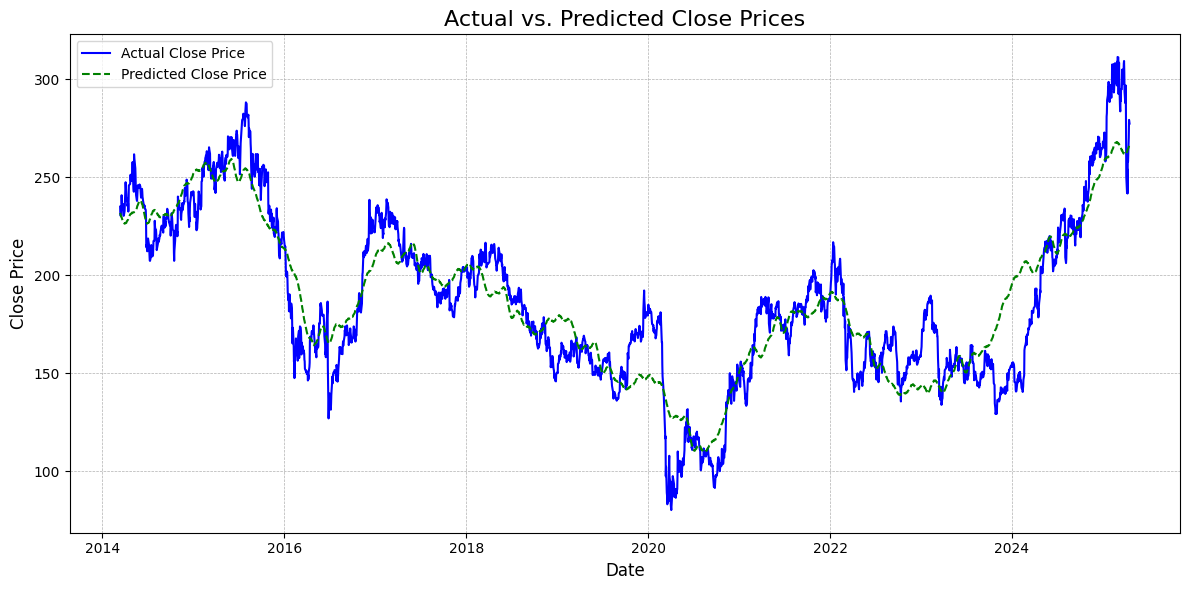

In [ ]:
# Merging actual and predicted values for Close price
close_merged = pd.merge(close_data, close_forecast[['ds', 'yhat']], on='ds')

# Calculating metrics for Close price
close_mse = mean_squared_error(close_merged['y'], close_merged['yhat'])
close_rmse = np.sqrt(close_mse)
close_mae = mean_absolute_error(close_merged['y'], close_merged['yhat'])
close_mape = calculate_mape(close_merged['y'], close_merged['yhat'])
close_r2 = r2_score(close_merged['y'], close_merged['yhat'])

print("\nClose Price Model Evaluation Metrics:")
print(f"MSE: {close_mse:.4f}")
print(f"RMSE: {close_rmse:.4f}")
print(f"MAE: {close_mae:.4f}")
print(f"MAPE:{close_mape:.4f}")
print(f"R²: {close_r2:.4f}")

# Plot for Close Price
plt.figure(figsize=(12, 6))
plt.plot(close_merged['ds'], close_merged['y'], label='Actual Close Price', color='blue')
plt.plot(close_merged['ds'], close_merged['yhat'], label='Predicted Close Price', color='green', linestyle='--')
plt.title('Actual vs. Predicted Close Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



#  30 Days Plot Future Predictions for Prophet

In [ ]:
# Creating a DataFrame for future dates (30 days)
open_future = prophet_model.make_future_dataframe(periods=30)
open_future = open_future[open_future['ds'] > open_data['ds'].max()]
open_forecast = prophet_model.predict(open_future)

close_model = Prophet(daily_seasonality=True)
close_model.fit(close_data)

close_future = close_model.make_future_dataframe(periods=30)
close_future = close_future[close_future['ds'] > close_data['ds'].max()]
close_forecast = close_model.predict(close_future)



13:20:34 - cmdstanpy - INFO - Chain [1] start processing
13:20:35 - cmdstanpy - INFO - Chain [1] done processing


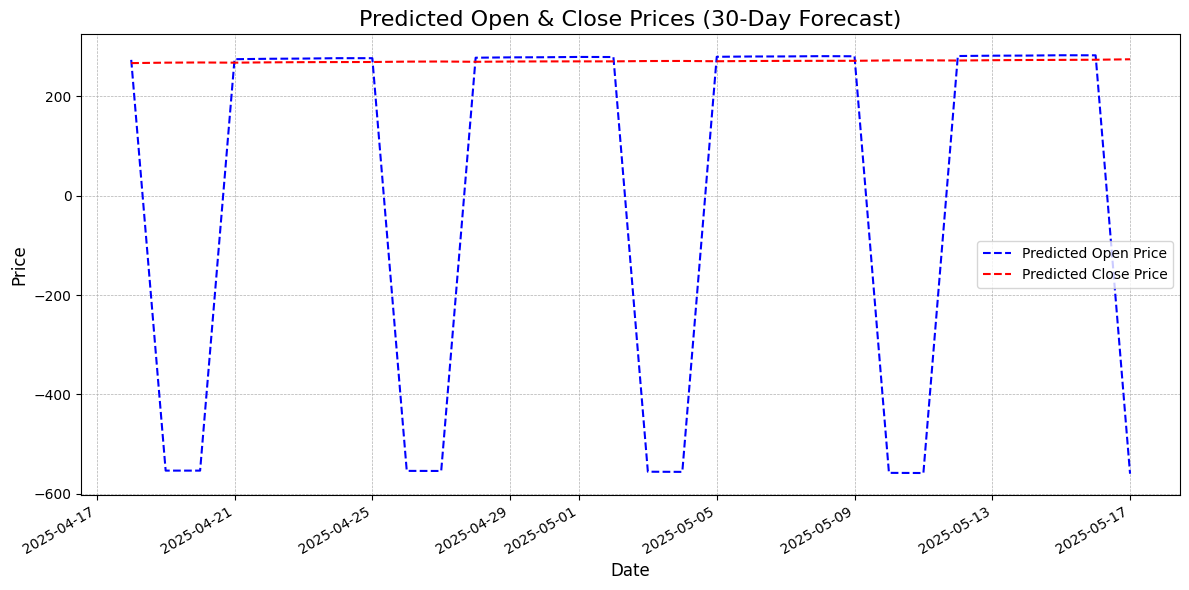

In [ ]:
futureProphet_df = pd.merge(open_forecast[['ds', 'yhat']], close_forecast[['ds', 'yhat']], on='ds', suffixes=('_open', '_close'))

plt.figure(figsize=(12, 6))
plt.plot(futureProphet_df['ds'], futureProphet_df['yhat_open'], label='Predicted Open Price', color='blue', linestyle='--')
plt.plot(futureProphet_df['ds'], futureProphet_df['yhat_close'], label='Predicted Close Price', color='red', linestyle='--')


# Formatting the plot
plt.title('Predicted Open & Close Prices (30-Day Forecast)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
print("\n30-Day Open and Close Price Forecast:")
print(futureProphet_df.tail(30))



30-Day Open and Close Price Forecast:
           ds   yhat_open  yhat_close
0  2025-04-18  273.716722  267.176094
1  2025-04-19 -553.383157  268.088581
2  2025-04-20 -553.418814  268.446956
3  2025-04-21  275.046148  268.047322
4  2025-04-22  275.913034  268.718908
5  2025-04-23  276.307160  269.087680
6  2025-04-24  277.097484  269.265233
7  2025-04-25  277.094385  269.402617
8  2025-04-26 -553.936159  270.175347
9  2025-04-27 -554.100423  270.388720
10 2025-04-28  278.041297  269.842947
11 2025-04-29  278.749773  270.371401
12 2025-04-30  278.974765  270.604139
13 2025-05-01  279.594247  270.656691
14 2025-05-02  279.418147  270.683785
15 2025-05-03 -555.601453  271.364268
16 2025-05-04 -555.919480  271.506331
17 2025-05-05  279.907148  270.912563
18 2025-05-06  280.497890  271.418134
19 2025-05-07  280.625322  271.654257
20 2025-05-08  281.173987  271.736935
21 2025-05-09  280.950138  271.820665
22 2025-05-10 -557.911950  272.583346
23 2025-05-11 -558.220396  272.831511
24 2025-05-

# ARIMA Model

In [ ]:

import yfinance as yf
import pmdarima
from pmdarima import auto_arima
from datetime import date, timedelta
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Function to find the best ARIMA order
def find_best_arima(series):
    try:
        return auto_arima(series, seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
    except Exception as e:
        print(f"Error finding best ARIMA order: {e}")
        return None

ticker_symbol = 'BARC.L'
start_date = '2014-01-01'
end_date = date.today().strftime('%Y-%m-%d')

# Downloading historical stock data
barclays_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')

# Ensuring the data is sorted by date
barclays_data.sort_index(inplace=True)

# Flatten MultiIndex columns (if they exist)
barclays_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in barclays_data.columns.values]


open_prices = barclays_data['Open_BARC.L']
close_prices = barclays_data['Close_BARC.L']

best_model_open = find_best_arima(open_prices)
best_order_open = best_model_open.order if best_model_open else (0,1,0)

best_model_close = find_best_arima(close_prices)
best_order_close = best_model_close.order if best_model_close else (0,0,0)



train_size = int(len(open_prices) * 0.8)
open_train, open_test = open_prices[:train_size], open_prices[train_size:]
close_train, close_test = close_prices[:train_size], close_prices[train_size:]

open_model = ARIMA(open_train, order=best_order_open).fit()
close_model = ARIMA(close_train, order=best_order_close).fit()

open_pred = open_model.forecast(steps=len(open_test))
close_pred = close_model.forecast(steps=len(close_test))

open_rmse = np.sqrt(mean_squared_error(open_test, open_pred))
open_mape = calculate_mape(open_test.values, open_pred)
close_rmse = np.sqrt(mean_squared_error(close_test, close_pred))
close_mape = calculate_mape(close_test.values, close_pred)


# Defining actual and predicted values for Open and Close Prices

open_train_actual = open_train
open_train_pred = open_model.fittedvalues
open_test_actual = open_test
open_test_pred = open_pred

close_train_actual = close_train
close_train_pred = close_model.fittedvalues
close_test_actual = close_test
close_test_pred = close_pred

[*********************100%***********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16138.187, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16173.495, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16148.529, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16149.570, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16171.496, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16143.612, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16143.663, Time=0.70 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16130.010, Time=0.56 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16128.432, Time=0.63 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16127.508, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16148.853, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=16128.196, Time=0.45 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=16130.038, Time=1.48 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=16125.509, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0


Open Price Model Evaluation Metrics:
MSE: 218.9536
RMSE: 54.6354
MAE: 10.4480
MAPE:20.7083
R²: 0.8853


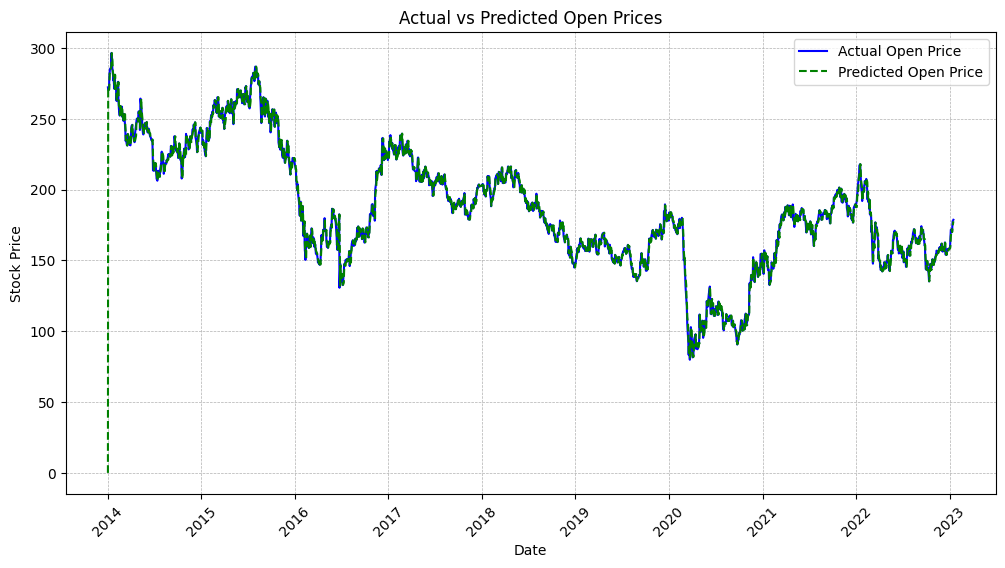

In [ ]:

print("\nOpen Price Model Evaluation Metrics:")
print(f"MSE: {open_mse:.4f}")
print(f"RMSE: {open_rmse:.4f}")
print(f"MAE: {open_mae:.4f}")
print(f"MAPE:{open_mape:.4f}")
print(f"R²: {open_r2:.4f}")

# Ploting Actual and Predicted Open Prices
plt.figure(figsize=(12,6))
plt.plot(open_train_actual.index, open_train_actual, label='Actual Open Price', color='blue')
plt.plot(open_train_actual.index, open_train_pred, label='Predicted Open Price', linestyle='dashed', color='green')
plt.legend()
plt.title('Actual vs Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()




Close Price Model Evaluation Metrics:
MSE: 318.2332
RMSE: 53.5886
MAE: 13.5308
MAPE:21.1498
R²: 0.8330


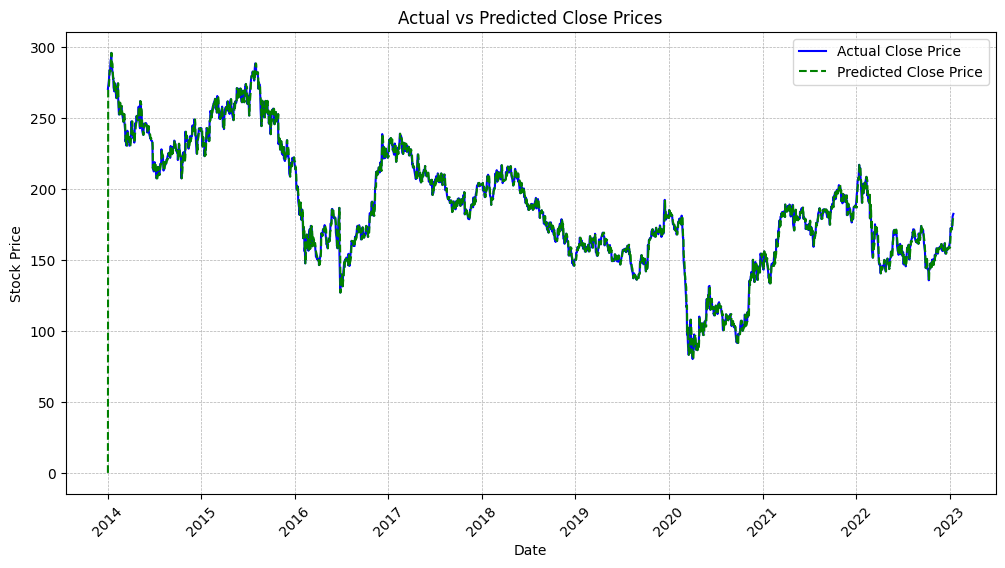

In [ ]:
print("\nClose Price Model Evaluation Metrics:")
print(f"MSE: {close_mse:.4f}")
print(f"RMSE: {close_rmse:.4f}")
print(f"MAE: {close_mae:.4f}")
print(f"MAPE:{close_mape:.4f}")
print(f"R²: {close_r2:.4f}")


# Ploting Actual and Predicted Close Prices
plt.figure(figsize=(12,6))
plt.plot(close_train_actual.index, close_train_actual, label='Actual Close Price', color='blue')
plt.plot(close_train_actual.index, close_train_pred, label='Predicted Close Price', linestyle='dashed', color='green')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()


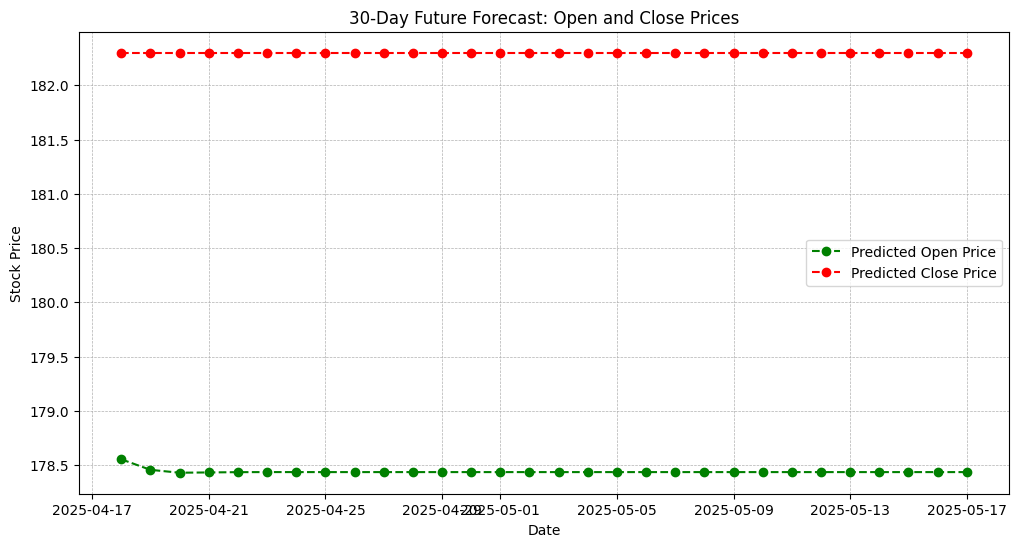

In [ ]:

# Generating future dates
future_dates = pd.date_range(start=barclays_data.index[-1] + timedelta(days=1), periods=30, freq='D')

open_forecast = open_model.forecast(steps=30)
close_forecast = close_model.forecast(steps=30)

# Creating DataFrame with actual and predicted values
futureARIMA_df = pd.DataFrame({
    'Date': future_dates,
    'Open_Predicted': open_forecast,
    'Close_Predicted': close_forecast
})
futureARIMA_df.set_index('Date', inplace=True)





# Ploting Future 30 Days Prediction
plt.figure(figsize=(12,6))
plt.plot(futureARIMA_df.index, futureARIMA_df['Open_Predicted'], label='Predicted Open Price', linestyle='--', marker='o', color='green')
plt.plot(futureARIMA_df.index, futureARIMA_df['Close_Predicted'], label='Predicted Close Price', linestyle='--', marker='o', color='red')
plt.title('30-Day Future Forecast: Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()


In [ ]:
print("\n 30-Day Open and Close Price Forecast:\n")
print(futureARIMA_df.head(30))



 30-Day Open and Close Price Forecast:

            Open_Predicted  Close_Predicted
Date                                       
2025-04-18      178.553875       182.300552
2025-04-19      178.456898       182.300552
2025-04-20      178.430305       182.300552
2025-04-21      178.432917       182.300552
2025-04-22      178.435488       182.300552
2025-04-23      178.436230       182.300552
2025-04-24      178.436153       182.300552
2025-04-25      178.436086       182.300552
2025-04-26      178.436065       182.300552
2025-04-27      178.436067       182.300552
2025-04-28      178.436069       182.300552
2025-04-29      178.436069       182.300552
2025-04-30      178.436069       182.300552
2025-05-01      178.436069       182.300552
2025-05-02      178.436069       182.300552
2025-05-03      178.436069       182.300552
2025-05-04      178.436069       182.300552
2025-05-05      178.436069       182.300552
2025-05-06      178.436069       182.300552
2025-05-07      178.436069       18

In [ ]:
ensemble_df = pd.DataFrame()
ensemble_df['Date'] = futureLSTM_df['Date']
ensemble_df['LSTM'] = futureLSTM_df['Predicted Open']
ensemble_df['ARIMA'] = futureARIMA_df['Open_Predicted']
ensemble_df['Prophet'] = futureProphet_df['yhat_open']

# Average prediction
ensemble_df['Ensemble_Prediction'] = ensemble_df[['LSTM', 'ARIMA', 'Prophet']].mean(axis=1)

# Evaluate ensemble
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = open_train_actual[:len(ensemble_df)]
mae = mean_absolute_error(y_true, ensemble_df['Ensemble_Prediction'])
rmse = mean_squared_error(y_true, ensemble_df['Ensemble_Prediction'], squared=False)
mape = calculate_mape(y_true, ensemble_df['Ensemble_Prediction'])

print(f"Ensemble MAE: {mae}")
print(f"Ensemble RMSE: {rmse}")
# print(f"Esnemble MAPE:{mape:.4f}")


Ensemble MAE: 132.80407135184834
Ensemble RMSE: 218.44296893369534


#### Statistica Comparisons of Models

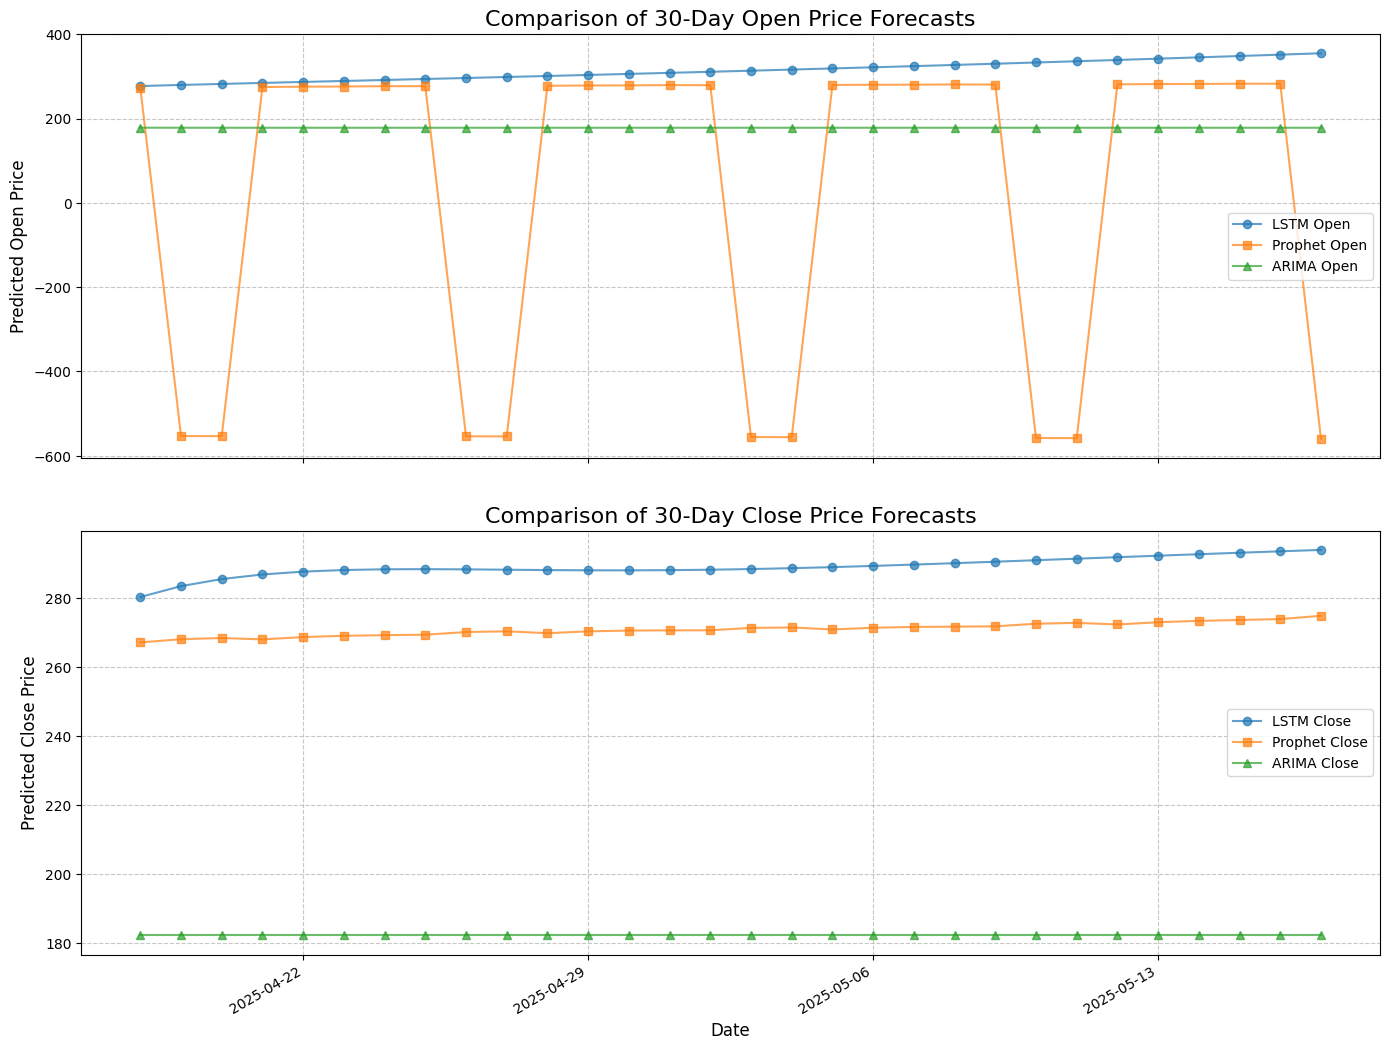

Statistical Summary of 30-Day Forecasts:
   LSTM_Open_Mean  LSTM_Open_Std  LSTM_Close_Mean  LSTM_Close_Std  \
0      314.000688      23.306501       289.052782         2.88156   

   Prophet_Open_Mean  Prophet_Open_Std  Prophet_Close_Mean  Prophet_Close_Std  \
0          28.757703        389.230424          270.935252            1.91517   

   ARIMA_Open_Mean  ARIMA_Open_Std  ARIMA_Close_Mean  ARIMA_Close_Std  
0       178.440382        0.021812        182.300552              0.0  

Forecast Volatility (Standard Deviation):
     Model  Open Price Volatility  Close Price Volatility
0     LSTM              23.306501                 2.88156
1  Prophet             389.230424                 1.91517
2    ARIMA               0.021812                 0.00000

Percent Differences Between Models (based on mean forecasts):
LSTM vs Prophet (Open): 90.84%
LSTM vs ARIMA (Open): 43.17%
Prophet vs ARIMA (Open): 520.50%
LSTM vs Prophet (Close): 6.27%
LSTM vs ARIMA (Close): 36.93%
Prophet vs ARIMA (Clo

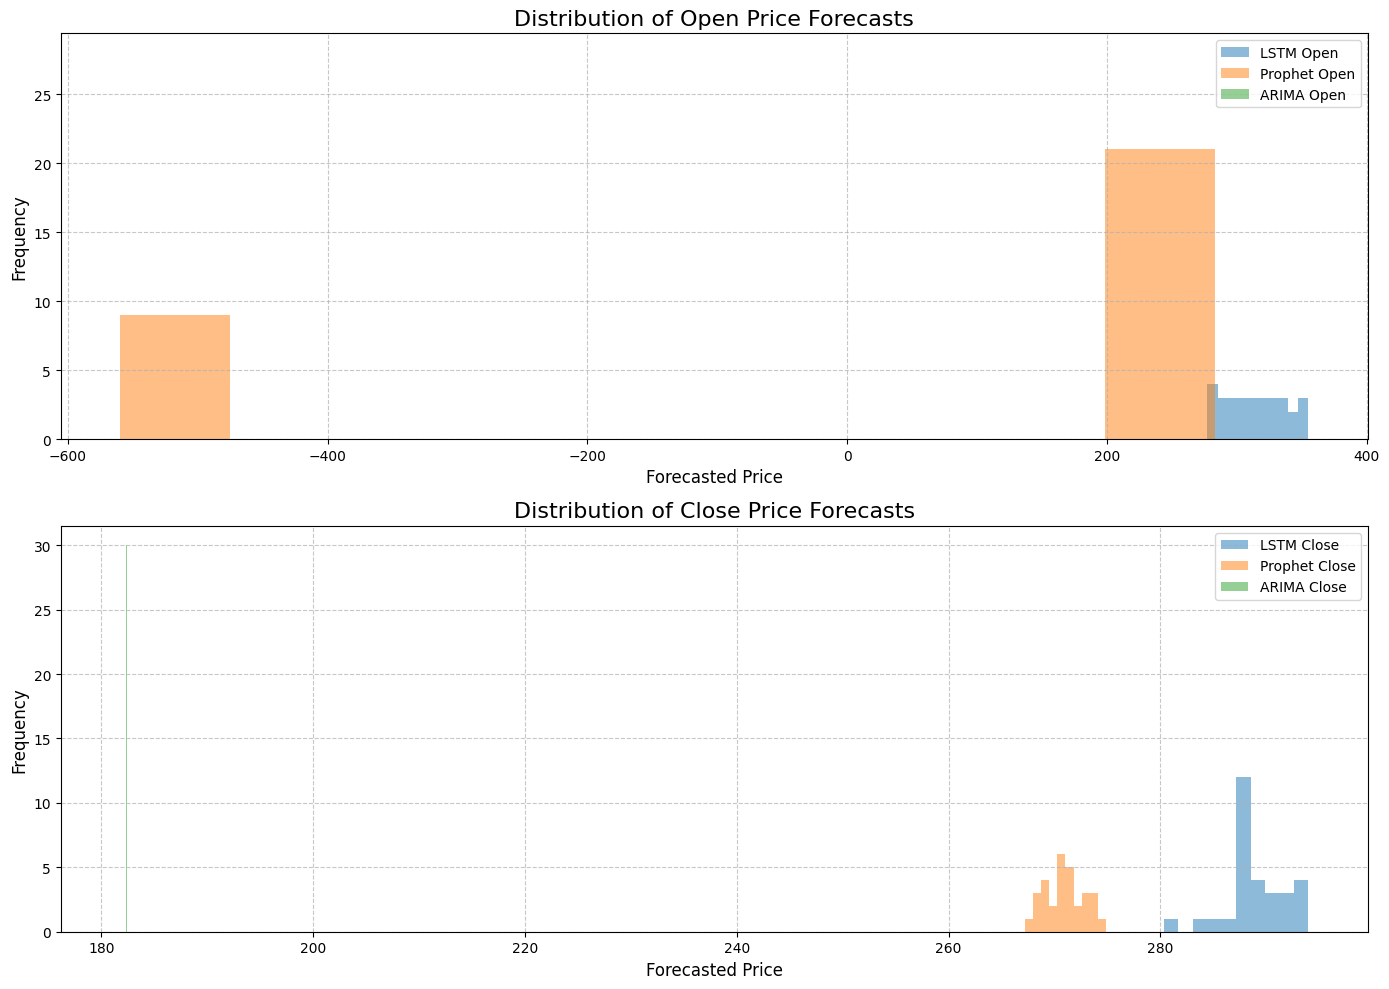

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta


# Creating a function to align and compare the forecasts
def compare_forecasts(lstm_df, prophet_df, arima_df):
    # Ensure all DataFrames have the same date format
    if 'Date' in lstm_df.columns:
        lstm_df = lstm_df.set_index('Date')

    # For Prophet, rename columns for consistency
    if 'ds' in prophet_df.columns:
        prophet_df = prophet_df.rename(columns={
            'ds': 'Date',
            'yhat_open': 'Predicted Open',
            'yhat_close': 'Predicted Close'
        }).set_index('Date')

    # Creating figure with two subplots (Open and Close prices)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

    # Ploting Open Price forecasts
    ax1.plot(lstm_df.index, lstm_df['Predicted Open'], label='LSTM Open', marker='o', linestyle='-', alpha=0.7)
    ax1.plot(prophet_df.index, prophet_df['Predicted Open'], label='Prophet Open', marker='s', linestyle='-', alpha=0.7)
    ax1.plot(arima_df.index, arima_df['Open_Predicted'], label='ARIMA Open', marker='^', linestyle='-', alpha=0.7)

    ax1.set_title('Comparison of 30-Day Open Price Forecasts', fontsize=16)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Predicted Open Price', fontsize=12)
    ax1.legend(loc='best')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

    # Ploting Close Price forecasts
    ax2.plot(lstm_df.index, lstm_df['Predicted Close'], label='LSTM Close', marker='o', linestyle='-', alpha=0.7)
    ax2.plot(prophet_df.index, prophet_df['Predicted Close'], label='Prophet Close', marker='s', linestyle='-', alpha=0.7)
    ax2.plot(arima_df.index, arima_df['Close_Predicted'], label='ARIMA Close', marker='^', linestyle='-', alpha=0.7)

    ax2.set_title('Comparison of 30-Day Close Price Forecasts', fontsize=16)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Predicted Close Price', fontsize=12)
    ax2.legend(loc='best')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

    # Creating a combined DataFrame for statistical comparison
    # Aligning dates first
    dates = sorted(set(list(lstm_df.index) + list(prophet_df.index) + list(arima_df.index)))
    combined_df = pd.DataFrame(index=dates)

    # Adding LSTM predictions
    combined_df['LSTM_Open'] = np.nan
    combined_df['LSTM_Close'] = np.nan
    for date in lstm_df.index:
        if date in combined_df.index:
            combined_df.loc[date, 'LSTM_Open'] = lstm_df.loc[date, 'Predicted Open']
            combined_df.loc[date, 'LSTM_Close'] = lstm_df.loc[date, 'Predicted Close']

    # Adding Prophet predictions
    combined_df['Prophet_Open'] = np.nan
    combined_df['Prophet_Close'] = np.nan
    for date in prophet_df.index:
        if date in combined_df.index:
            combined_df.loc[date, 'Prophet_Open'] = prophet_df.loc[date, 'Predicted Open']
            combined_df.loc[date, 'Prophet_Close'] = prophet_df.loc[date, 'Predicted Close']

    # Adding ARIMA predictions
    combined_df['ARIMA_Open'] = np.nan
    combined_df['ARIMA_Close'] = np.nan
    for date in arima_df.index:
        if date in combined_df.index:
            combined_df.loc[date, 'ARIMA_Open'] = arima_df.loc[date, 'Open_Predicted']
            combined_df.loc[date, 'ARIMA_Close'] = arima_df.loc[date, 'Close_Predicted']

    # Calculating statistics
    stats_df = pd.DataFrame({
        'LSTM_Open_Mean': [combined_df['LSTM_Open'].mean()],
        'LSTM_Open_Std': [combined_df['LSTM_Open'].std()],
        'LSTM_Close_Mean': [combined_df['LSTM_Close'].mean()],
        'LSTM_Close_Std': [combined_df['LSTM_Close'].std()],
        'Prophet_Open_Mean': [combined_df['Prophet_Open'].mean()],
        'Prophet_Open_Std': [combined_df['Prophet_Open'].std()],
        'Prophet_Close_Mean': [combined_df['Prophet_Close'].mean()],
        'Prophet_Close_Std': [combined_df['Prophet_Close'].std()],
        'ARIMA_Open_Mean': [combined_df['ARIMA_Open'].mean()],
        'ARIMA_Open_Std': [combined_df['ARIMA_Open'].std()],
        'ARIMA_Close_Mean': [combined_df['ARIMA_Close'].mean()],
        'ARIMA_Close_Std': [combined_df['ARIMA_Close'].std()],
    })

    return combined_df, stats_df

combined_forecasts, forecast_stats = compare_forecasts(futureLSTM_df, futureProphet_df, futureARIMA_df)

# Displaying statistical summary
print("Statistical Summary of 30-Day Forecasts:")
print(forecast_stats)

# Creating a table showing model volatility comparison
print("\nForecast Volatility (Standard Deviation):")
volatility_comparison = pd.DataFrame({
    'Model': ['LSTM', 'Prophet', 'ARIMA'],
    'Open Price Volatility': [
        forecast_stats['LSTM_Open_Std'].values[0],
        forecast_stats['Prophet_Open_Std'].values[0],
        forecast_stats['ARIMA_Open_Std'].values[0]
    ],
    'Close Price Volatility': [
        forecast_stats['LSTM_Close_Std'].values[0],
        forecast_stats['Prophet_Close_Std'].values[0],
        forecast_stats['ARIMA_Close_Std'].values[0]
    ]
})
print(volatility_comparison)

# Calculating percent differences between models
print("\nPercent Differences Between Models (based on mean forecasts):")
lstm_prophet_open_diff = abs(forecast_stats['LSTM_Open_Mean'].values[0] - forecast_stats['Prophet_Open_Mean'].values[0]) / forecast_stats['LSTM_Open_Mean'].values[0] * 100
lstm_arima_open_diff = abs(forecast_stats['LSTM_Open_Mean'].values[0] - forecast_stats['ARIMA_Open_Mean'].values[0]) / forecast_stats['LSTM_Open_Mean'].values[0] * 100
prophet_arima_open_diff = abs(forecast_stats['Prophet_Open_Mean'].values[0] - forecast_stats['ARIMA_Open_Mean'].values[0]) / forecast_stats['Prophet_Open_Mean'].values[0] * 100

lstm_prophet_close_diff = abs(forecast_stats['LSTM_Close_Mean'].values[0] - forecast_stats['Prophet_Close_Mean'].values[0]) / forecast_stats['LSTM_Close_Mean'].values[0] * 100
lstm_arima_close_diff = abs(forecast_stats['LSTM_Close_Mean'].values[0] - forecast_stats['ARIMA_Close_Mean'].values[0]) / forecast_stats['LSTM_Close_Mean'].values[0] * 100
prophet_arima_close_diff = abs(forecast_stats['Prophet_Close_Mean'].values[0] - forecast_stats['ARIMA_Close_Mean'].values[0]) / forecast_stats['Prophet_Close_Mean'].values[0] * 100

print(f"LSTM vs Prophet (Open): {lstm_prophet_open_diff:.2f}%")
print(f"LSTM vs ARIMA (Open): {lstm_arima_open_diff:.2f}%")
print(f"Prophet vs ARIMA (Open): {prophet_arima_open_diff:.2f}%")
print(f"LSTM vs Prophet (Close): {lstm_prophet_close_diff:.2f}%")
print(f"LSTM vs ARIMA (Close): {lstm_arima_close_diff:.2f}%")
print(f"Prophet vs ARIMA (Close): {prophet_arima_close_diff:.2f}%")

# Ploting the distribution of forecasts
plt.figure(figsize=(14, 10))

# Subplot for Open Price distribution
plt.subplot(2, 1, 1)
plt.hist(combined_forecasts['LSTM_Open'].dropna(), alpha=0.5, bins=10, label='LSTM Open')
plt.hist(combined_forecasts['Prophet_Open'].dropna(), alpha=0.5, bins=10, label='Prophet Open')
plt.hist(combined_forecasts['ARIMA_Open'].dropna(), alpha=0.5, bins=10, label='ARIMA Open')
plt.title('Distribution of Open Price Forecasts', fontsize=16)
plt.xlabel('Forecasted Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot for Close Price distribution
plt.subplot(2, 1, 2)
plt.hist(combined_forecasts['LSTM_Close'].dropna(), alpha=0.5, bins=10, label='LSTM Close')
plt.hist(combined_forecasts['Prophet_Close'].dropna(), alpha=0.5, bins=10, label='Prophet Close')
plt.hist(combined_forecasts['ARIMA_Close'].dropna(), alpha=0.5, bins=10, label='ARIMA Close')
plt.title('Distribution of Close Price Forecasts', fontsize=16)
plt.xlabel('Forecasted Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()